In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


In [2]:
df = pd.read_csv(r'C:\Users\Admin\Desktop\data science assighnments\Timeseries\Timeseries\exchange_rate.csv')

In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [58]:
df

,Ex_rate,Rolling Mean,Rolling Std,Ex_rate_diff,SES
date,,,,,
1990-01-07,0.788600,0.785729,0.002089,NaN,0.788600
1990-01-08,0.791000,0.786514,0.002875,0.002400,0.788600
1990-01-09,0.793900,0.788243,0.003189,0.002900,0.789080
1990-01-10,0.789400,0.788629,0.003134,-0.004500,0.790044
1990-01-11,0.791700,0.789443,0.003077,0.002300,0.789915
...,...,...,...,...,...
2010-10-06,0.718494,0.719190,0.001231,-0.000207,0.722429
2010-10-07,0.721839,0.719231,0.001323,0.003345,0.721642
2010-10-08,0.723197,0.720028,0.001789,0.001358,0.721681


In [54]:
df.describe()

,Ex_rate,Rolling Mean,Rolling Std,Ex_rate_diff,SES
count,7582.000000,7582.000000,7582.000000,7581.000000,7582.000000
mean,0.776967,0.776993,0.005110,-0.000009,0.777011
std,0.136674,0.136541,0.003872,0.006051,0.136429
min,0.483297,0.487954,0.000483,-0.150073,0.489285
25%,0.701237,0.702175,0.002823,-0.002400,0.703024
50%,0.761298,0.761279,0.004249,0.000000,0.761306
75%,0.873569,0.873900,0.006195,0.002500,0.874417
max,1.102536,1.099282,0.057108,0.151362,1.094822


In [55]:
df.columns

Index(['Ex_rate', 'Rolling Mean', 'Rolling Std', 'Ex_rate_diff', 'SES'], dtype='object')

In [57]:

# Ensure the index is in datetime format
df.index = pd.to_datetime(df.index)


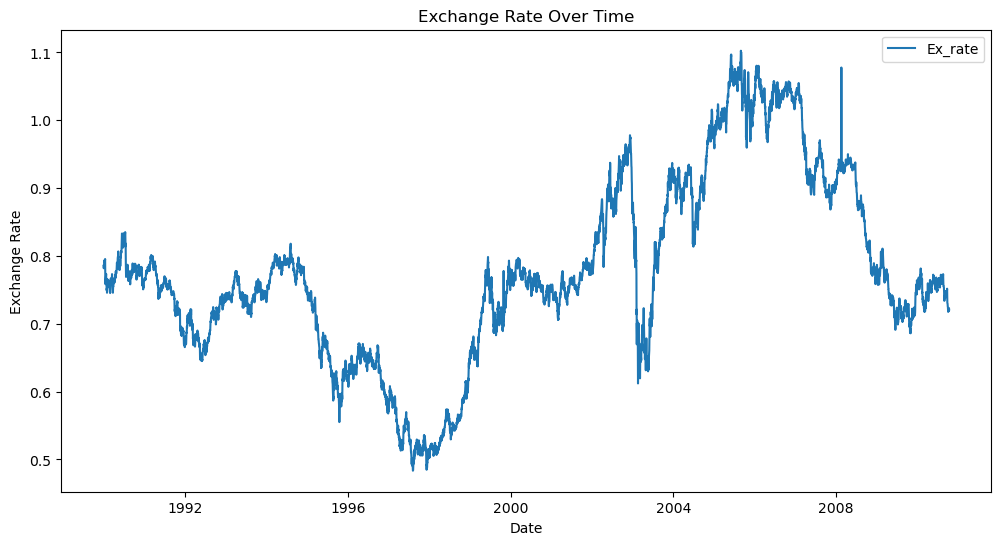

In [10]:
# Assuming the DataFrame 'df' has a datetime index and a column named 'Exchange Rate'
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Ex_rate'], label='Ex_rate')
plt.title('Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


In [11]:
df.isnull().sum()

Ex_rate    0
dtype: int64

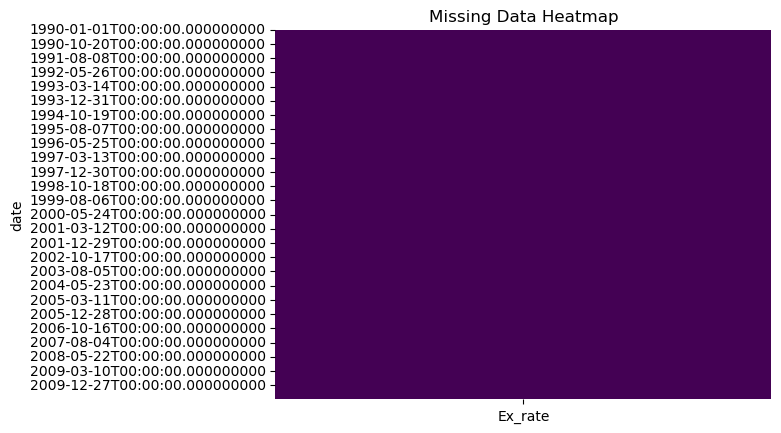

In [12]:
# Plot missing values if any
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()


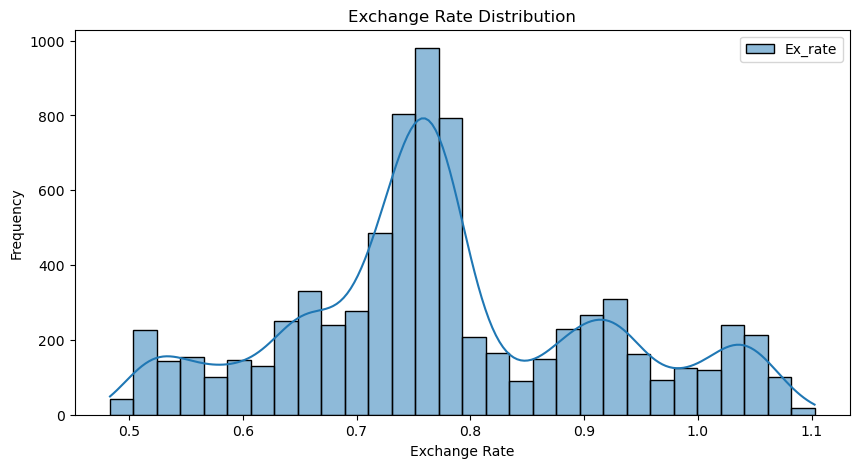

In [13]:
# Plot histogram to check data distribution
plt.figure(figsize=(10, 5))
sns.histplot(df, kde=True, bins=30)
plt.title('Exchange Rate Distribution')
plt.xlabel('Exchange Rate')
plt.ylabel('Frequency')
plt.show()


In [14]:
# Recalculate Rolling Mean and Rolling Std with a smaller window (e.g., 7 days)
df['Rolling Mean'] = df['Ex_rate'].rolling(window=7).mean()
df['Rolling Std'] = df['Ex_rate'].rolling(window=7).std()


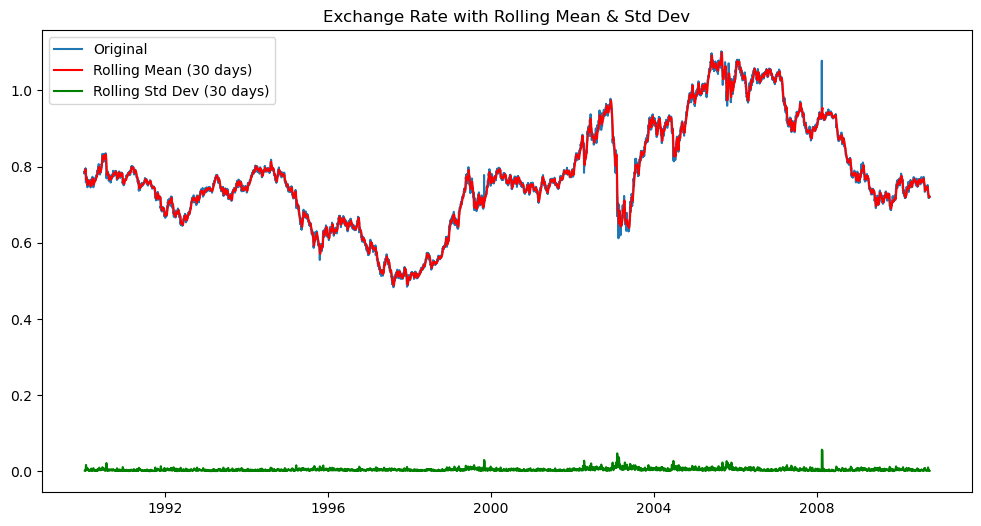

In [15]:

plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='Original')
plt.plot(df['Rolling Mean'], label='Rolling Mean (30 days)', color='red')
plt.plot(df['Rolling Std'], label='Rolling Std Dev (30 days)', color='green')
plt.title('Exchange Rate with Rolling Mean & Std Dev')
plt.legend()
plt.show()

In [16]:
# Decompose the time series
decomposition = seasonal_decompose(df['Ex_rate'], model='additive', period=365)


<Figure size 1200x1000 with 0 Axes>

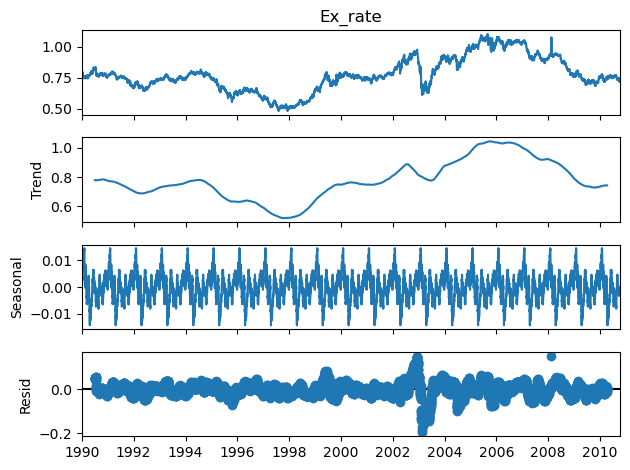

In [17]:
# Plot the decomposition
plt.figure(figsize=(12, 10))
decomposition.plot()
plt.show()

In [18]:
# Interpolate missing data
df['Ex_rate'] = df['Ex_rate'].interpolate(method='time')


In [19]:
# Verify no missing values remain
print(df.isnull().sum())


Ex_rate         0
Rolling Mean    6
Rolling Std     6
dtype: int64


In [20]:
df['Rolling Mean'] = df['Rolling Mean'].interpolate(method='linear')
df['Rolling Std'] = df['Rolling Std'].interpolate(method='linear')

In [21]:
df.isnull().sum()

Ex_rate         0
Rolling Mean    6
Rolling Std     6
dtype: int64

In [22]:

# Drop rows with missing values in Rolling Mean and Rolling Std
df.dropna(subset=['Rolling Mean', 'Rolling Std'], inplace=True)


In [23]:
df.isnull().sum()

Ex_rate         0
Rolling Mean    0
Rolling Std     0
dtype: int64

In [24]:
# Select only numeric columns for correlation matrix
numeric_df = df.select_dtypes(include=['float64', 'int64'])


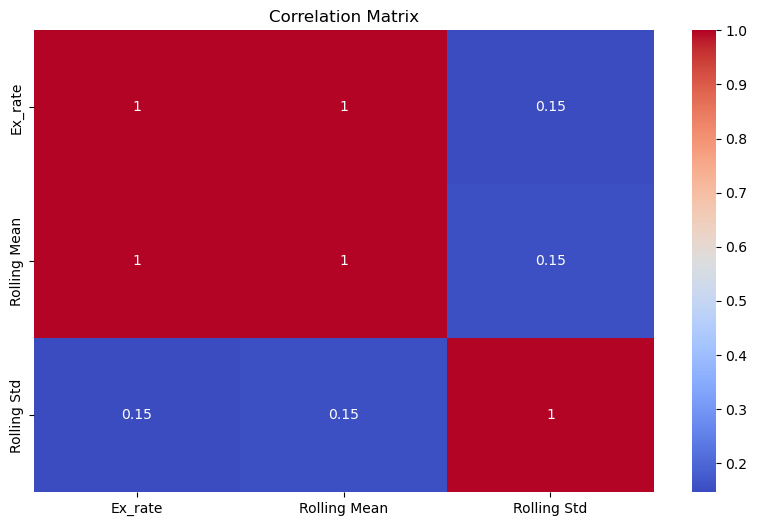

In [25]:

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [26]:
# Perform ADF test to check stationarity
result = adfuller(df['Ex_rate'].dropna())


In [27]:

print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -1.6655587990070106
p-value: 0.4489392277988079


In [28]:
if result[1] > 0.05:
    print("The series is non-stationary. Differencing is needed.")
else:
    print("The series is stationary.")

The series is non-stationary. Differencing is needed.


In [29]:
# First difference the series to make it stationary
df['Ex_rate_diff'] = df['Ex_rate'].diff()


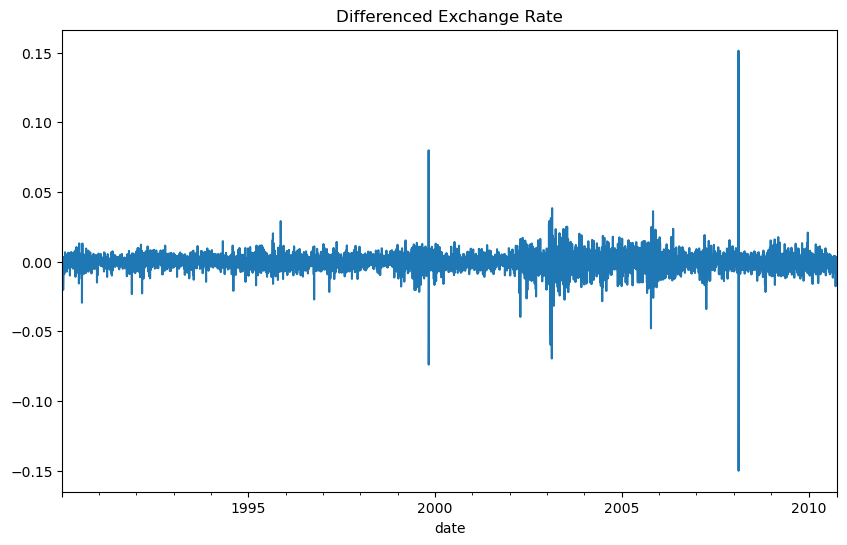

In [30]:
# Plot the differenced series
df['Ex_rate_diff'].plot(figsize=(10, 6))
plt.title('Differenced Exchange Rate')
plt.show()

<Figure size 1200x600 with 0 Axes>

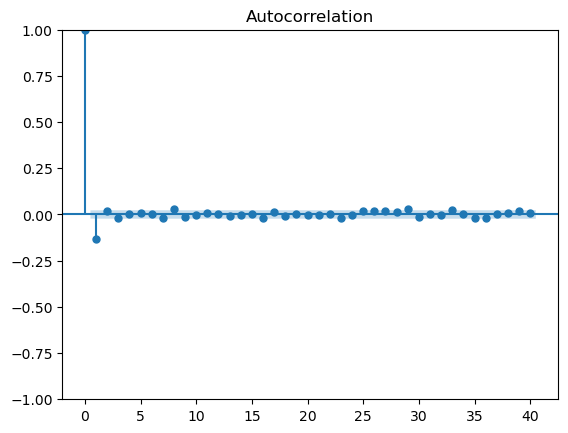

In [31]:
# Plot ACF and PACF to determine p and q
plt.figure(figsize=(12, 6))
plot_acf(df['Ex_rate_diff'].dropna(), lags=40)
plt.show()


<Figure size 1200x600 with 0 Axes>

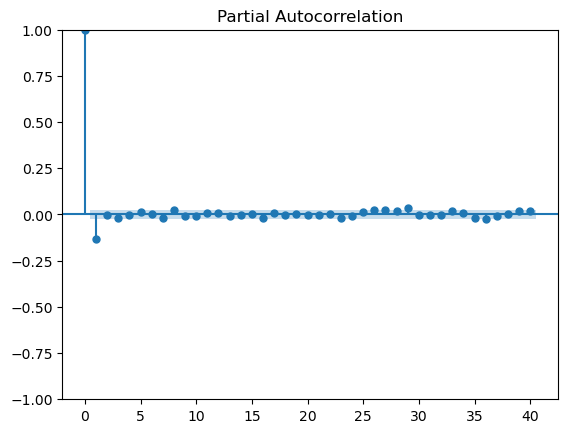

In [32]:
plt.figure(figsize=(12, 6))
plot_pacf(df['Ex_rate_diff'].dropna(), lags=40)
plt.show()


In [33]:

# Fit ARIMA(1, 1, 0) model
model = ARIMA(df['Ex_rate'], order=(1, 1, 0))
model_fit = model.fit()


D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [34]:
# Print the summary of the model fit
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7582
Model:                 ARIMA(1, 1, 0)   Log Likelihood               28029.574
Date:                Sun, 22 Dec 2024   AIC                         -56055.149
Time:                        15:35:58   BIC                         -56041.282
Sample:                    01-07-1990   HQIC                        -56050.389
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1314      0.002    -64.383      0.000      -0.135      -0.127
sigma2      3.598e-05   9.95e-08    361.488      0.000    3.58e-05    3.62e-05
Ljung-Box (L1) (Q):                   0.00   Jarque-

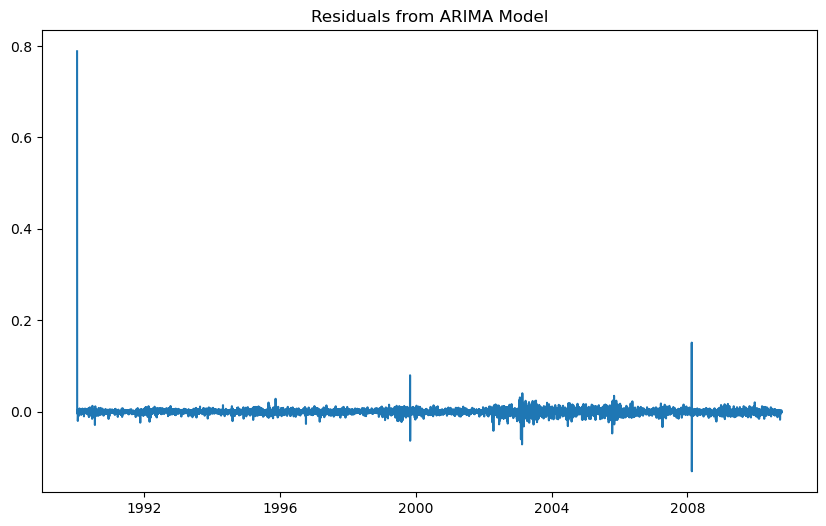

In [35]:
# Plot the residuals
residuals = model_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals from ARIMA Model')
plt.show()


<Figure size 1000x600 with 0 Axes>

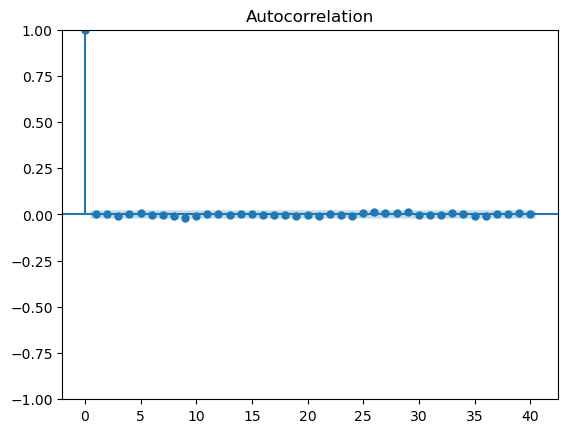

In [36]:

# Plot ACF of residuals
plt.figure(figsize=(10, 6))
plot_acf(residuals, lags=40)
plt.show()

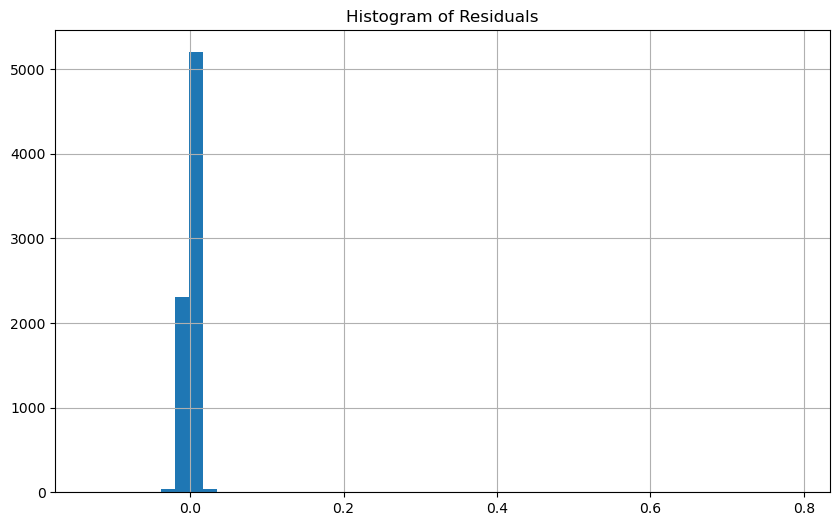

In [37]:
# Check for normality in residuals
plt.figure(figsize=(10, 6))
residuals.hist(bins=50)
plt.title('Histogram of Residuals')
plt.show()

In [38]:
# Apply Simple Exponential Smoothing
model = SimpleExpSmoothing(df['Ex_rate']).fit(smoothing_level=0.2, optimized=False)
df['SES'] = model.fittedvalues


D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


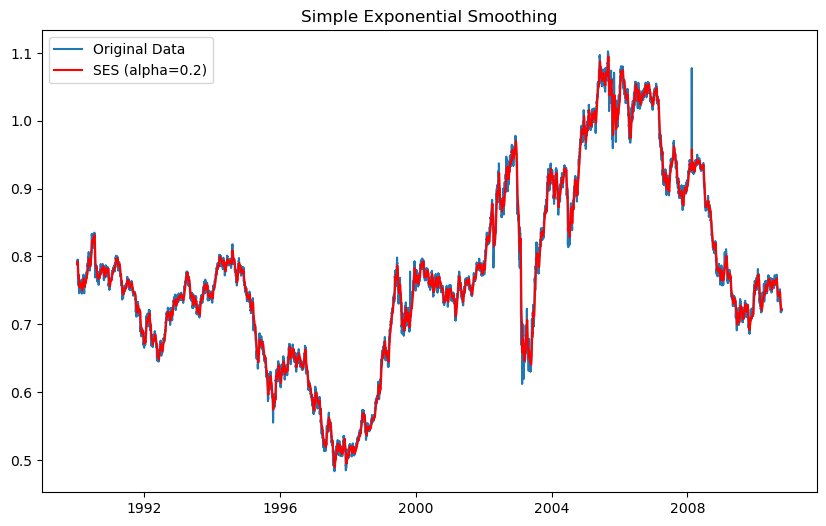

In [39]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(df['Ex_rate'], label='Original Data')
plt.plot(df['SES'], label='SES (alpha=0.2)', color='red')
plt.title('Simple Exponential Smoothing')
plt.legend()
plt.show()

In [40]:
# Fit the model with automatic alpha optimization
model = SimpleExpSmoothing(df['Ex_rate']).fit()


D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [41]:
# Fit the model with automatic alpha optimization
model = SimpleExpSmoothing(df['Ex_rate']).fit()


D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [42]:

# Forecast and evaluate
fitted_values = model.fittedvalues
mse = mean_squared_error(df['Ex_rate'].dropna(), fitted_values)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 3.59818826119811e-05


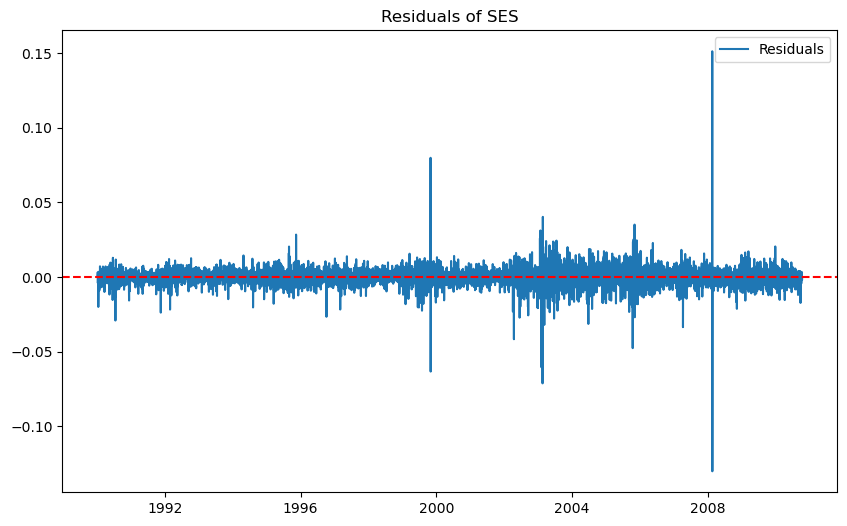

In [43]:
residuals = df['Ex_rate'] - model.fittedvalues

plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals of SES')
plt.legend()
plt.show()

In [44]:
forecast = model.forecast(steps=10)
print("Forecasted Values:", forecast)

Forecasted Values: 2010-10-11    0.720862
2010-10-12    0.720862
2010-10-13    0.720862
2010-10-14    0.720862
2010-10-15    0.720862
2010-10-16    0.720862
2010-10-17    0.720862
2010-10-18    0.720862
2010-10-19    0.720862
2010-10-20    0.720862
Freq: D, dtype: float64


In [45]:
# Forecast future values
forecast_steps = 10
forecast = model.forecast(steps=forecast_steps)

# Generate a proper index for the forecast
forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq='D')[1:]  # Adjust 'D' as needed
forecast = pd.Series(forecast, index=forecast_index)



In [46]:

smoothed_value = model.fittedvalues.iloc[-1]
forecast = pd.Series([smoothed_value] * forecast_steps, index=forecast_index)
print(forecast)

2010-10-11    0.721106
2010-10-12    0.721106
2010-10-13    0.721106
2010-10-14    0.721106
2010-10-15    0.721106
2010-10-16    0.721106
2010-10-17    0.721106
2010-10-18    0.721106
2010-10-19    0.721106
2010-10-20    0.721106
Freq: D, dtype: float64


In [76]:
# Extracting the first 10 rows of actual data using .iloc
actual_data = df.iloc[:11]

print(actual_data)


            Ex_rate  Rolling Mean  Rolling Std  Ex_rate_diff       SES
date                                                                  
1990-01-07   0.7886      0.785729     0.002089           NaN  0.788600
1990-01-08   0.7910      0.786514     0.002875        0.0024  0.788600
1990-01-09   0.7939      0.788243     0.003189        0.0029  0.789080
1990-01-10   0.7894      0.788629     0.003134       -0.0045  0.790044
1990-01-11   0.7917      0.789443     0.003077        0.0023  0.789915
1990-01-12   0.7941      0.790757     0.002762        0.0024  0.790272
1990-01-13   0.7935      0.791743     0.002207       -0.0006  0.791038
1990-01-14   0.7954      0.792714     0.002086        0.0019  0.791530
1990-01-15   0.7751      0.790443     0.007039       -0.0203  0.792304
1990-01-16   0.7622      0.785914     0.012513       -0.0129  0.788863
1990-01-17   0.7583      0.781471     0.016082       -0.0039  0.783531


In [77]:
# Check for NaN values in actual_data and forecast
if actual_data.isnull().any().any() or forecast.isnull().any().any():
    print("Warning: NaN values found in the data. Removing...")
    # Remove NaN values if found
    actual_data = actual_data.dropna()
    forecast = forecast.dropna()

In [80]:
print("Length of actual data (last 10 rows):", len(actual_data_10))
print("Length of forecast data (last 10 rows):", len(forecast_10))

Length of actual data (last 10 rows): 10
Length of forecast data (last 10 rows): 10


In [81]:
actual_data_10 = actual_data.tail(10).values  # Convert to numpy array if necessary
forecast_10 = forecast[-10:].values  # Convert to numpy array if necessary

In [83]:
actual_data_10 = actual_data_10[:, 0] 

In [84]:
actual_data_10

array([0.791 , 0.7939, 0.7894, 0.7917, 0.7941, 0.7935, 0.7954, 0.7751,
       0.7622, 0.7583])

In [85]:
mse = mean_squared_error(actual_data_10, forecast_10)
mae = mean_absolute_error(actual_data_10, forecast_10)
rmse = np.sqrt(mse)

In [86]:

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 0.004190758938281979
Mean Absolute Error (MAE): 0.06335383601868146
Root Mean Squared Error (RMSE): 0.06473607138436792


In [ ]:
Findings :- Overall, the forecast model performs well based on the calculated error metrics.
            The low MSE, MAE, and RMSE values indicate that the model predictions are close to actual values, 
            suggesting it could be useful for making decisions based on this data. 